(ch_reproject)=
# Reprojecting raster data

A very common procedure in geoprocessing is to reproject geo data between different coordinate reference systems. In the script, we cover examples for [vector data](ch_ogr_CT), where the general approach is that one has to transform every individual geometry of a layer file. With raster data, this is a bit different as we have only one raster. Likewise, by switching between different coordinate systems, the original pixel structure often does not 1:1 translate into the "new" raster file. This is why for every reprojection one needs to define a resampling method (nearest neighbor, cubic convolution, etc.). In this chapter, we do not provide any guidance or information on which reprojection rule to use when. There is plenty of information out there, and probably in your remote sensing class you dove extensively into this topic. What we do here is to go step-by-step over the process of reprojecting a raster file into a different coordinate systems.

As example, we are taking the same dataset as in the chapter on the [affine transformation](ch_geotransform). We transform the data from the WGS84 coordinate reference system (EPSG 4326) into UTM zone 20S (EPSG 32720). Let's start by loading the dataset again and check the coordinate system as well as the affine transformation:


In [15]:
import os
from osgeo import gdal, ogr, osr
gdal.DontUseExceptions()

In [6]:
path = "D:/OneDrive - Conservation Biogeography Lab/_TEACHING/__Classes-Modules_HUB/M8_Geoprocessing-with-python/02_RasterData/Assignment02/"
ds = gdal.Open(path + "tileID_410_y2000.tif")

In [53]:
cols = ds.RasterXSize
rows = ds.RasterYSize
nbands = ds.RasterCount
dType = ds.GetRasterBand(1).DataType
cols, rows, nbands, dType

(1529, 1380, 1, 5)

In [9]:
pr = ds.GetProjection()
pr

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [10]:
gt = ds.GetGeoTransform()
gt

(-63.86859973338657,
 0.00026949458523585647,
 0.0,
 -24.446662310500248,
 0.0,
 -0.00026949458523585647)

Ok, so far so good. Nothing that we have not seen before. Now, let's suppose we want at a later stage take that image, classify it into the classes "woodland" and "other" and then calculate the area of each class. In the current coordinate system, we would potentially make a (large) mistake. THus, we will have to reproject the file into a matching coordinate reference system. The general steps for doing so are:
1. Get the coordinates of the maximum extent in x- and y- direction
2. Convert these points into the new coordinate reference system
3. Generate the affine transformation of the new dataset. Calculate also the number of columns and rows that this dataset should have.
4. Create a new dataset using the properties defined in 3.
5. Do the reprojection

## Deine maximum extent
Here, we apply the general properties that the affine transformation and the image properties give us

In [14]:
ulx, uly = gt[0], gt[3]
lrx = ulx + cols * gt[1]
lry = uly + rows * gt[5]
ulx, uly, lrx, lry


(-63.86859973338657,
 -24.446662310500248,
 -63.456542512560944,
 -24.81856483812573)

## Extent in target CRS
Now, we need to see where these points are located inside the new CRS. We have [learned before](ch_ogr_CT), that for reprojecting points between different CRS, we need (1) the point in form of a geometry, (2) a rule for translation:

In [40]:
ul = ogr.Geometry(ogr.wkbPoint)
ul.AddPoint(uly, ulx)
lr = ogr.Geometry(ogr.wkbPoint)
lr.AddPoint(lry, lrx)
print(ul, lr)

POINT Z (-24.4466623105002 -63.8685997333866 0) POINT Z (-24.8185648381257 -63.4565425125609 0)


In [41]:
fromSR = osr.SpatialReference()
fromSR.ImportFromWkt(pr)
toSR = osr.SpatialReference()
toSR.ImportFromEPSG(32720)
cT = osr.CoordinateTransformation(fromSR, toSR)

In [42]:
ul.Transform(cT)
lr.Transform(cT)
print(ul, lr)

POINT Z (411959.15493595 7296044.08855107 0) POINT Z (453862.686417869 7255064.90853486 0)


Cool, this is done. Now we can move to generate a new affine transformation and calculate the number of columns and rows. Since we are working with Landsat data, we define the pixel size of the new dataset to be ``30m``.

## New ``gt`` and colums/rows

In [43]:
newGT = (ul.GetX(), 30, 0, ul.GetY(), 0, -30)
newGT

(411959.15493595024, 30, 0, 7296044.088551067, 0, -30)

In [52]:
newCols = int((lr.GetX() - ul.GetX()) / 30)
newRows = int((lr.GetY() - ul.GetY()) / -30)
newCols, newRows

(1396, 1365)

## New raster file and reprojection
With this information, we can now create a new rasterfile. I am going to do this in memory, but you can obviously also do this right away on your hard drive

In [46]:
newDS = gdal.GetDriverByName('MEM').Create('', newCols, newRows, nbands, dType)
newDS.SetGeoTransform(newGT)
newDS.SetProjection(toSR.ExportToWkt()) # caution: the CRS of a raster file needs to be defined as a wellknown text (wkt)

0

Ok, now we are ready to reproject the image. As already mentioned, we will take the simples resampling method (nearest neighbor). The syntax here is the following:

``gdal.ReprojectImage(origImage, newImage, CRS_origImage, CRS_newImage, resamplingRule)``

In [47]:
gdal.ReprojectImage(ds, newDS, pr, toSR.ExportToWkt(), gdal.GRA_NearestNeighbour)

0

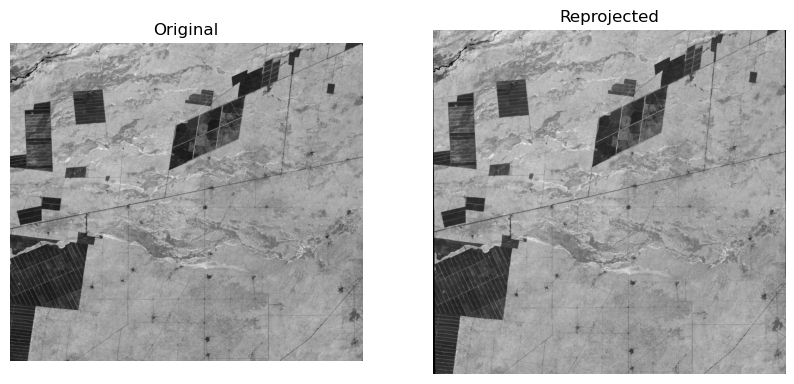

In [49]:
# Create a matplotlib figure and axis for ds and newDS
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ds.GetRasterBand(1).ReadAsArray(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(newDS.GetRasterBand(1).ReadAsArray(), cmap='gray')
axs[1].set_title('Reprojected')
axs[1].axis('off') 
plt.show()

This is it! The rule can be applied to any other image. You see, that the dimensions have changed slighty (compare ``cols / rows`` vs ``newCols / newRules``). If this was a classication image (i.e., a catergorical raster) you could now calculate areas of each class by summing up all pixels with a given class and then multiplying the result by the pixel area.